# An introduction to simulations with msprime

We've split this workshop into three parts:
 
 1. Introduction to tree sequences (30 minutes) (Georgia)
 2. Introduction to simulating with `msprime` (30 minutes) (Georgia)
 3. Calculating population genetics statistics with simulated datasets (30 minutes) (Jerome)
 
#### Presenter details
 
*Jerome Kelleher* (`jerome.kelleher` at `well.ox.ac.uk`) is a Senior Statistical Programmer at the Big Data Institute and the University of Oxford, UK.

*Georgia Tsambos* (`gtsambos` at `student.unimelb.edu.au`) is a PhD student in statistical genetics at Melbourne Integrative Genomics, which is part of the University of Melbourne, Australia.

#### Main reference

[1] Kelleher, J., Etheridge, A. M., & McVean, G. (2016). Efficient Coalescent Simulation and Genealogical Analysis for Large Sample Sizes. PLOS Computational Biology, 12(5), e1004842. https://doi.org/10.1371/journal.pcbi.1004842
 
 #### Creative Commons Licence
 These materials were designed for SMBE Speciation 2019. They can be re-used, but please say where you got them from!

# 1. Introduction to tree sequences

This notebook provides a 30 minute introduction to the tree sequence data structure that underlies `msprime`, and shows you how to use basic features of the `tskit` package.

### Things we'll cover in this notebook
 - 1.1 [Why use tree sequences?](#why_use_ts) 
 - 1.2 [Trees](#trees)
 - 1.3 [Tree sequences](#tree_sequences)
 - 1.4 [Table encoding](#table_representation)
 - 1.5 [Storing variation](#variation)


In [1]:
import tskit

<a id='why_use_ts'></a>
## 1.1 Why use tree sequences?

Genetic sequences are BIG and VERY REPETITIVE:

```
   ...GTAACGCGATAAGAGATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGAGATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGTAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGTAATAGCGTA...
```
Because of this, you are probably used to storing your data in a compressed format, and decompressing it only when you need to perform analyses or query the data. Doing this can be time-consuming and computationally expensive, however.

### The key idea
Common haplotypes in a sample are often simply a consequence of some common history. Thus, if you know this history (as we always do in simulations!), storing it directly is often more convenient and efficient than storing the raw haplotypes.  
A *tree sequence* is an encoding of a complete genealogy for a sample of genomes at each genomic location  [1].
They offer a few potential benefits to population geneticists when compared with traditional genetic file formats:

- They can store large simulated datasets extremely compactly. (Often >100 times smaller than VCFs for real-sized datasets!) 

- As they hold rich detail about the history of the sample, many important processes can be observed directly from the tree structure. So a tree sequence is often more informative than raw genotype/haplotype data, even though it is also more compact.

- They can be queried and modified extremely quickly. In later workshops we will see that this enables quick calculation of many important population statistics.

In this first part of our workshop, we'll introduce you to tree sequences, and show you how to extract basic information from tree sequence files with the `tskit` package.
 

<a id='trees'></a>
## 1.2 Trees

At a single nucleotide base, the genealogy of a sample at can be represented by a single tree.

The tree consists of *nodes*, which represent the alleles held by different chromosomes in the history of the sample, and *edges*, which represent genealogical relationships between the alleles.

Suppose we have a sample of 4 alleles, each from a different DNA sequence, and we wish to understand their history. We could represent this history with a tree like this one:

<p><img src="pics/simple-tree.png" alt="" width="45%"/></p>
 
The 4 *sample nodes* are those labelled 0 - 3 at the leaves of the tree. The other nodes are *ancestral nodes*: these are the alleles held by individuals that are ancestral to the sample.

The height of the nodes in the tree indicates the age of the node, and an edge joining a pair of nodes is used to indicate that the allele of the lower node is descended from the allele of the upper node.

<a id='tree_sequences'></a>
## 1.3 Tree sequences

The sample history encoded by a tree at a single base will typically also apply to some interval of neighbouring bases. However, due to recombinations in the history of the sample, the genealogy will typically be different at more distant locations on the chromosome, and so must be represented by a different tree. Thus, the history of a sample of sequences can be encoded in a sequence of trees - a tree sequence!

<p><img src="pics/tree-sequence.png" alt="" width="70%"/></p>

The endpoints of the intervals are the locations at which recombination has occurred in the history of the sample. 

Notice that the adjacent trees look very similar to each other. This makes sense: each recombination should correspond to a single "tree edit" (or "subtree-prune-and-regraft" operation). Because these recombinations are specific to particular lineages, many genealogical relationships may be unaffected by a given recombination. This means that topological features are often shared over many neighbouring trees.


### tskit: a toolkit for tree sequences

(insert some general blurby words about what tskit is)

We'll start by importing the `tskit` package. 
We'll also need the SVG module to plot our tree sequences nicely.

In [2]:
import tskit
from IPython.display import SVG

Tree sequence files can be loaded using the `load` function...

In [3]:
ts = tskit.load("example-1.trees")

... and plotted using the imported SVG module, as long as they are fairly simple.

Tree on chromosomal interval (0.0, 3.0)


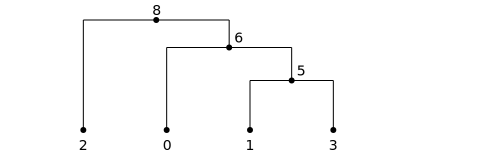


Tree on chromosomal interval (3.0, 7.0)


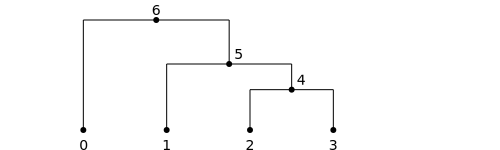


Tree on chromosomal interval (7.0, 10.0)


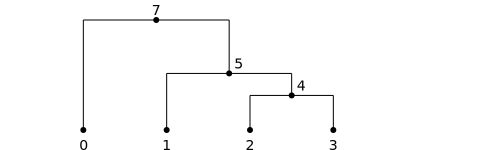

In [4]:
for tree in ts.trees():
    print("Tree on chromosomal interval", tree.interval)
    display(SVG(tree.draw(width=500, height=150)))
    print()

Many key properties of the tree sequence can be queried directly from the tree sequence: for example, the total number of nodes and the total number of edges (a rough measure of the 'size' of the tree sequence which often corresponds to the speed with which tree sequence calculations are likely to run):

In [5]:
ts.num_nodes

9

In [6]:
ts.num_edges

11

### Iterating through the trees

The trees in the tree sequence can be accessed in a few different different ways.
If you wish to access each of the trees sequentially, you can use the `trees()` iterator as we did above.

We can also access the tree spanning a given genomic position:

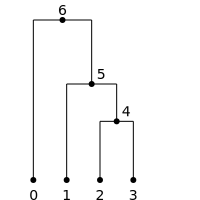

In [7]:
SVG(ts.at(6).draw())

Many key features of each tree can be accessed in this way (show some useful examples)

<a id='table_representation'></a>
## 1.4 Table representation

It turns out that each tree sequence object can be entirely specified by a set of tables. Instead of storing each tree individually, each individual topological feature is stored as a row in a relevant table.

Our example tree sequence can be represented with the following NodeTable and EdgeTable:

<p><img src="pics/tree-sequence-with-tables.png" alt="" width="40%"/></p>
<p><img src="pics/tree-sequence.png" alt="" width="70%"/></p>

There are other tables like Mutations, Sites, Populations, etc. that we will see later in this workshop.

Any topological feature that is common to several trees must only be recorded once in the corresponding collection of tables. For instance, all of the trees in our example tree sequence have an edge joining nodes 1 and 5, and this edge is recorded just once in the table.

<p><img src="pics/tables-with-highlights.png" alt="" width="25%"/></p>
<p><img src="pics/tree-sequence-with-highlight.png" alt="" width="70%"/></p>


This *succinctness* is one of main reasons why the tree sequence format is so compact!

### With tskit: TableCollections

In [8]:
tables = ts.tables

In [9]:
print(tables.nodes)

id	flags	population	individual	time	metadata
0	1	-1	-1	0.00000000000000	
1	1	-1	-1	0.00000000000000	
2	1	-1	-1	0.00000000000000	
3	1	-1	-1	0.00000000000000	
4	0	-1	-1	1.10000000000000	
5	0	-1	-1	1.80000000000000	
6	0	-1	-1	3.00000000000000	
7	0	-1	-1	3.50000000000000	
8	0	-1	-1	4.00000000000000	


In [10]:
print(tables.edges)

id	left		right		parent	child
0	3.00000000	10.00000000	4	2
1	3.00000000	10.00000000	4	3
2	0.00000000	10.00000000	5	1
3	0.00000000	3.00000000	5	3
4	3.00000000	10.00000000	5	4
5	0.00000000	7.00000000	6	0
6	0.00000000	7.00000000	6	5
7	7.00000000	10.00000000	7	0
8	7.00000000	10.00000000	7	5
9	0.00000000	3.00000000	8	2
10	0.00000000	3.00000000	8	6


These collections of tables are the 'guts' of the tree sequence format. To modify a tree sequence, you'll have to extract the relevant tables, make changes and convert the tables back into a tree sequence. 

**Exercise:** Can you modify the following Table Collection until the corresponding tree sequence looks like the one in this plot? (make simple example)

<a id='variation'></a>
## 1.5 Variation
 
Variation is a consequence of mutations in the history of the sample. Thus, by adding some information about mutations to our tree sequences, we can use them to encode full haplotype data for each of our samples. 

We need to store the genomic location of each variant site, as well as the lineage of the tree affected by the mutation. (This corresponds to an edge in the tree sequence). The subsample of haplotypes with the mutated type is simply the subset of nodes in the part of the tree that descends from the mutation.

<p><img src="pics/tree-sequence-with-mutations.png" alt="" width="70%"/></p>

This information is encoded with two extra tables: a site table showing the locations of the variant sites, and a mutations table showing the lineage of the tree affected by the mutation.

<p><img src="pics/tables-with-mutations.png" alt="" width="70%"/></p>

The mutation and alleles highlighted in pink correspond to the highlighted rows of the site and mutation tables.

Note that even if we had 400 or 400 000 samples, we would still only need two rows to store information about the alleles held by the samples at this position!

### With tskit: mutations

Here's a tree sequence file corresponding to our example above.

Tree on interval (0.0, 3.0)


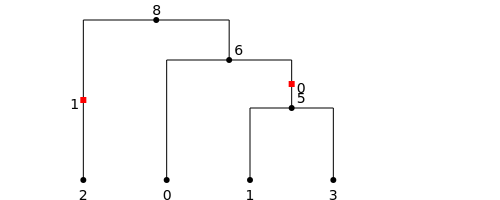


Tree on interval (3.0, 7.0)


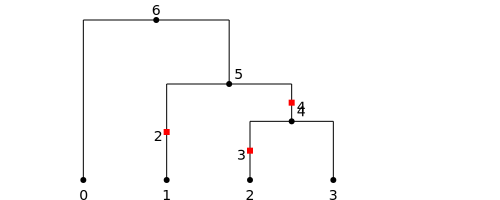


Tree on interval (7.0, 10.0)


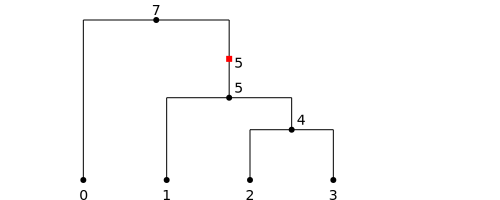

In [11]:
ts = tskit.load("example-2.trees")

for tree in ts.trees():
    print("Tree on interval", tree.interval)
    display(SVG(tree.draw(width=500)))
    print()

In [12]:
tables = ts.tables
print(tables.mutations)

id	site	node	derived_state	parent	metadata
0	0	5	1	-1	
1	1	2	1	-1	
2	2	1	1	-1	
3	3	2	1	-1	
4	4	4	1	-1	
5	5	5	1	-1	


In [13]:
print(tables.sites)

id	position	ancestral_state	metadata
0	1.20000000	0	
1	2.50000000	0	
2	3.30000000	0	
3	3.90000000	0	
4	6.40000000	0	
5	8.40000000	0	


Iterating through variants:

In [14]:
for var in ts.variants():
    print(var.genotypes)

[0 1 0 1]
[0 0 1 0]
[0 1 0 0]
[0 0 1 0]
[0 0 1 1]
[0 1 1 1]


All genotypes at once: (warning: this can be big!)

In [15]:
ts.genotype_matrix()

array([[0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 1, 1]], dtype=uint8)

**Exercise:** Trees and tree sequence objects have many useful inbuilt methods and attributes. Have a play around with these in the time before the next part of the workshop.

See the official documentation for [tree sequences](https://tskit.readthedocs.io/en/latest/python-api.html?highlight=SVG#tskit.TreeSequence) and [trees](https://tskit.readthedocs.io/en/latest/python-api.html?highlight=SVG#tskit.Tree) for a fuller description of these.